### Task 2

Name: Sai Srujan<br>
API: USGS Earthquake Catalog

This notebook covers Task 2 - Data Preparation and Analysis.<br>

In [1]:
import json
import os
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Directory where the raw data is stored and the years for which the data is collected.

In [2]:
# directory where the data is stored
dir_eq_raw = "raw_eq_files"

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

years = ["2019", "2020", "2021"]

## Data Preprocessing

Iterates over the directory in which the data files are present and groups the filepaths according to the year which would be used later for processing and merging the data

In [3]:
earthquake_files = {}
# Check if we are processing a directory    
if(os.path.isdir(dir_eq_raw)):
    # Iterate over all files present in the directory
    for file in os.listdir(dir_eq_raw):
        # Split the filename to parse
        file_name = file.split("-")
        # Check if the files are of earthquake data
        if file_name[0] == "earthquake":
            file_year = file_name[2].split(".")[0]
            file_path = os.path.join(dir_eq_raw,file)
            # Add the file path to the list for that particular year
            if file_year in earthquake_files:
                earthquake_files[file_year].append(file_path)
            else :
                earthquake_files[file_year] = [file_path]
print("Raw data files found for every year are:")
for year in years:
    print("%s: %d files" % (year, len(earthquake_files[year])))

Raw data files found for every year are:
2019: 12 files
2020: 12 files
2021: 12 files


Since, data collected is month-wise for each year, there should be 12 files for every year. 

This function is used to read the raw data files of earthquakes and store them into a data frame by making the data consistent and dropping some unwanted columns. All the dataframes are then stored in a list for each year which will further be used to check the missing values and then merge them according to year.

In [4]:
def read_data(path):
    input_file = open(path, "r")
    jdata = input_file.read()
    data = json.loads(jdata)
    
    # Creates a dataframe of the json data
    earthquake_data_df = pd.DataFrame(data['features'])
    earthquake_prop_df = pd.DataFrame(list(earthquake_data_df['properties']))
    earthquake_prop_df['id'] = earthquake_data_df['id']
    
    # Dropping the unwanted columns which does not provide important information for analysis
    earthquake_prop_df =  earthquake_prop_df.drop(columns=['detail', 'url', 'nst', 'ids'])
    
    # Removing the trailing and leading commas from the data to make it consistent
    earthquake_prop_df['sources'] = earthquake_prop_df['sources'].str.strip(',')
    earthquake_prop_df['types'] = earthquake_prop_df['types'].str.strip(',')
    
    # Converting the integer timestamp to datetime object and renaming the columns appropriately
    earthquake_prop_df['time'] = pd.to_datetime(earthquake_prop_df['time'], unit='ms')
    earthquake_prop_df = earthquake_prop_df.rename(columns={"time": "EventTime"})
    earthquake_prop_df['updated'] = pd.to_datetime(earthquake_prop_df['updated'], unit='ms')
    earthquake_prop_df = earthquake_prop_df.rename(columns={"updated": "UpdatedTime"})
    
    # Splitting the regions and country/state
    earthquake_prop_df['region'] = np.where((earthquake_prop_df['place'].str.split(', ').str[0]).isnull(), earthquake_prop_df['place'], earthquake_prop_df['place'].str.split(', ').str[0])
    earthquake_prop_df['place'] = np.where((earthquake_prop_df['place'].str.split(', ').str[1]).isnull(), earthquake_prop_df['place'], earthquake_prop_df['place'].str.split(', ').str[1])
    earthquake_prop_df.set_index("id", inplace=True)
    input_file.close()
    return earthquake_prop_df

In [5]:
# Reading and parsing the data files for each year
earthquake_data = {}
for year in years:
    print("Parsing %s data files" % year)
    earthquake_data[year] = []
    for file_path in earthquake_files[year]:
        parsed_data = read_data(file_path)
        earthquake_data[year].append(parsed_data)

Parsing 2019 data files
Parsing 2020 data files
Parsing 2021 data files


This functions checks if the dataframe passed to the function has any missing values in the various columns and returns True if there are missing values, else returns False.

In [6]:
def check_missing_values(data):
    missing_values = data.isnull().sum()
    # Consider only the columns with missing values
    missing_values = missing_values[missing_values != 0]
    if len(missing_values) == 0:
        return False
    else:
        return True

Data of every month in a year is checked for missing values. If there are missing values in a column the column is added to the list of columns with more than 50% of the values missing or to the list of columns having less than 50% missing values.<br>

In [7]:
missing_count_gtf = []
missing_count_ltf = []
for year in years:
    for month_data in earthquake_data[year]:
        isMissing = check_missing_values(month_data)
        if(isMissing):
            missing_values = month_data.isnull().sum()
            missing_values = missing_values[missing_values != 0]
            dataLength = len(month_data)
            for key in missing_values.keys():
                # If missing value are more than 50%
                if (missing_values[key]/dataLength > 0.5):
                    # If key not in list then we add
                    if key not in missing_count_gtf:
                        missing_count_gtf.append(key)
                else :
                    # If key not in list then we add
                    if key not in missing_count_ltf:
                        missing_count_ltf.append(key)
print("Columns with more than 50% of the values missing:",missing_count_gtf)
print("Columns with less than 50% of the values missing:",missing_count_ltf)

Columns with more than 50% of the values missing: ['tz', 'felt', 'cdi', 'mmi', 'alert']
Columns with less than 50% of the values missing: ['dmin', 'gap', 'mag', 'magType', 'rms', 'place', 'region']


This function is used to fill in the missing values in the column. We only impute the values in the column where the percentage of missing values is less than 50% (from the list obtained above). We also drop the rows where the important values are missing.

In [8]:
def impute_missing_values(data):
    """ 
    Drops the row if magnitude, type of measure used to calculate magnitude or place is not present.
    We drop the rows if this data is missing as these are important values and data without this is not reliable.
    """
    data.dropna(subset=['mag', 'place', 'magType'], inplace=True, axis=0)  
    
    """
    The missing values in dmin column is filled with average of the column calculated based on grouping by place.
    We calculate the average grouping by place, as dmin value is Horizontal distance from the epicenter to the nearest station.
    So, grouping by place gives us a more reliable value to be filled for missing values.
    We calculate the dmin values mean based on place, if there are no values for a particular place we consider the whole column
    mean.
    """
    dmin_mean = data.groupby('place')['dmin'].mean()
    dmin_mean = dmin_mean.fillna(data['dmin'].mean())
    dmin_dict = dmin_mean.to_dict()
    data['dmin'] = data['dmin'].fillna(data['place'].map(dmin_dict))

    """
    The missing values in gap column is filled with average of the column calculated based on grouping by place.
    We calculate the average grouping by place, as gap value is the largest azimuthal gap between azimuthally adjacent stations.
    So, grouping by place gives us a more reliable value to be filled for missing values.
    We calculate the gap values mean based on place, if there are no values for a particular place we consider the whole column
    mean.
    """
    gap_mean = data.groupby('place')['gap'].mean()
    gap_mean = gap_mean.fillna(data['gap'].mean())
    gap_dict = gap_mean.to_dict()
    data['gap'] = data['gap'].fillna(data['place'].map(gap_dict))
    
    # rms is the measure of the fit of the observed arrival times to the predicted arrival times.
    # So we impute the missing values with the total column mean value.
    data.loc[data["rms"].isnull(),'rms'] = data['rms'].mean()

    return data
        

Parse through the data of every month for a particular year. We first check for missing values, drop the columns with missing values greater than 50% and then impute the values of other missing values where the percentage of missing values is less than 50% for that column. We parse the data of each month, fill the missing values first and then merge so that the values are more reliable when the average is calculated based on the month data.<br>
We merge all the data for that particular year only if the columns are same across all the months after dropping columns and imputing values.

In [9]:
eq_processed_data = {}
for year in years:
    print("Processing %s data" % year)
    eq_files = []
    for month_data in earthquake_data[year]:
        # Checks if there is any missing data
        isMissing = check_missing_values(month_data)
        if(isMissing):
            missing_values = month_data.isnull().sum()
            dataLength = len(month_data)
            for key in missing_values.keys():
                # If missing values are more than 50% then we drop that column
                if (missing_values[key]/dataLength > 0.5):
                    month_data = month_data.drop(columns=key)  
            # Other missing values are filled by calling the impute_missing_values function    
            imputed_data = impute_missing_values(month_data)
            eq_files.append(imputed_data)
    # Checking if all the columns in the dataframe are the same        
    if all([set(eq_files[0].columns) == set(eq_files[i].columns) for i, month in enumerate(months)]):
        eq_processed_data[year] = pd.concat(eq_files)
        # Removing the duplicate index values
        eq_processed_data[year] = eq_processed_data[year].groupby(eq_processed_data[year].index).first()
    else:
        print('Some have different columns - ', year)


Processing 2019 data
Processing 2020 data
Processing 2021 data


The data is processed, imputed with missing values and merged for every year.<br>
As data is merged and there are no errors, the same columns have a large percentage of missing values in every file and dropped from all the files.

After the missing values are filled and data is merged, we again check if all the data of various years(2019, 2020, 2021) have the same columns and also check if there are still any more missing values.

In [10]:
# Checks if all the columns are same across the different dataframes of the years
if all([set(eq_processed_data["2019"].columns) == set(eq_processed_data[year].columns) for year in years]):
    print('All have the same columns')
else:
    print('Some have different columns')  
for year in years:
    print("--", year)
    isMissing = check_missing_values(eq_processed_data[year])
    if not isMissing:
        print("No missing values found")
    else:
        print("%s data has missing values" % year)

All have the same columns
-- 2019
No missing values found
-- 2020
No missing values found
-- 2021
No missing values found


In [12]:
# Check if data is in proper format after all the pre processing steps for one of the year
eq_processed_data["2019"].head(5)

,mag,place,EventTime,UpdatedTime,status,tsunami,sig,net,code,sources,types,dmin,rms,gap,magType,type,title,region
id,,,,,,,,,,,,,,,,,,
aacse01910mgnbr,3.1,Gulf of Alaska,2019-01-22 14:51:06.158,2021-05-21 15:46:34.511,reviewed,0,148,aacse,01910mgnbr,aacse,"origin,phase-data",2.473000,0.76,208.666667,ml,earthquake,M 3.1 - Gulf of Alaska,Gulf of Alaska
aacse01910mi7ta,1.3,Alaska,2019-01-22 14:58:38.226,2021-05-21 15:46:34.033,reviewed,0,26,aacse,01910mi7ta,aacse,"origin,phase-data",0.597751,0.56,217.758308,ml,earthquake,"M 1.3 - 31 km N of Larsen Bay, Alaska",31 km N of Larsen Bay
aacse01910rnstf,2.0,Alaska,2019-01-22 23:24:24.115,2021-05-21 15:47:17.239,reviewed,0,62,aacse,01910rnstf,aacse,"origin,phase-data",0.597751,0.47,217.758308,ml,earthquake,"M 2.0 - 52 km ENE of Ouzinkie, Alaska",52 km ENE of Ouzinkie
aacse01910ruud8,2.3,Alaska Peninsula,2019-01-22 23:57:10.434,2021-05-21 15:47:16.643,reviewed,0,81,aacse,01910ruud8,aacse,"origin,phase-data",0.045673,0.86,194.333333,ml,earthquake,M 2.3 - Alaska Peninsula,Alaska Peninsula
aacse019122kazu,2.3,Alaska,2019-01-23 02:02:12.903,2021-05-21 15:46:33.435,reviewed,0,81,aacse,019122kazu,aacse,"origin,phase-data",0.597751,0.52,217.758308,ml,earthquake,"M 2.3 - 56 km SSE of King Salmon, Alaska",56 km SSE of King Salmon


## Data Analysis

 - Number of earthquakes that have occured every year in the last three years.

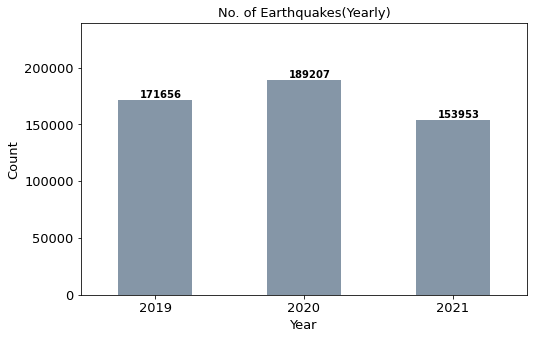

In [13]:
counts =[]
# Calculating the count of earthquakes for each year
for year in years:
    counts.append(len(eq_processed_data[year]))
# Creating a dataframe with the year and counts
eq_counts = pd.DataFrame({'year':years, 'count': counts}, index=years)
# Plotting a bar chart
neq_plt = eq_counts.plot(kind='bar', fontsize=13, figsize=(8,5), color="#8596a7", legend=False)
neq_plt.set_title("No. of Earthquakes(Yearly)", fontsize=13)
neq_plt.set_ylabel("Count", fontsize=13)
neq_plt.set_xlabel("Year", fontsize=13)
# Setting the y limit to ensure the values on top of bar are displayed properly
neq_plt.set_ylim(0, max(counts) + 50000)
# Displaying the x axis labels horizontally
plt.xticks(rotation=0)
# Display counts on top of bars
for i, v in enumerate(counts):
    neq_plt.text(i - 0.1, v, str(v), color='black', fontweight='bold', va='bottom')
plt.show()

It can be observed that the year 2020 had the most number of earthquakes, while the year 2021(last year) had least number of earthquakes when compared to the three years.<br>
There are at least 150,000 earthquakes that have occured every year.

- Number of earthquakes that have occured every month in a year

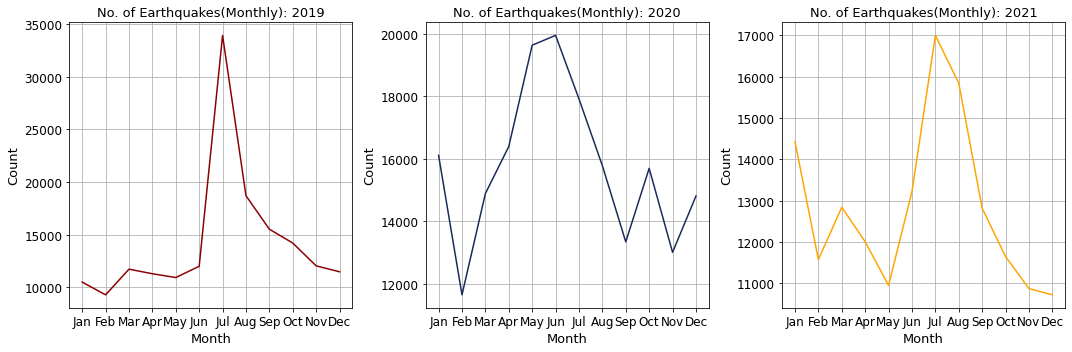

In [14]:
year_colors = {"2019": "darkred", "2020": "#1a2a5a", "2021": "orange"}
fig = plt.figure(figsize=(15,5))
for i, year in enumerate(years):
    # Adding a sub plot
    sub_plt = fig.add_subplot(1, 3, i+1)
    # Extracting the month value of the event date from each row
    month_data = eq_processed_data[year]['EventTime'].dt.month
    # Counting the number of earthquakes for each month
    values = month_data.value_counts()
    values = values.sort_index()
    # Plotting a line chart for every year
    month_plt = values.plot(legend=False, lw=1.5, color=year_colors[year], fontsize=12)
    month_plt.set_title("No. of Earthquakes(Monthly): %s" % year, fontsize=13)
    month_plt.set_ylabel("Count", fontsize=13)
    month_plt.set_xlabel("Month", fontsize=13)
    month_plt.set_xticks(np.arange(1,13))
    month_plt.set_xticklabels(months)
    month_plt.grid()
# Adjusting the spacing between plots
fig.tight_layout()

From the above plots, it can be observed that a large number of earthquakes have occured during the months of June - August. July has the most number of earthquakes in the year 2019, 2021 and June has the most number of earthquakes in 2020.

 - Magnitude is one of the factor that determines the severity of an earthquake. The minimum, maximum and the average magnitude of earthquakes for every year is calculated.

In [15]:
# Calculating the min, max and average of the magnitude(mag) column for each year
data = []
for year in years:
    yearData ={}
    yearData["Year"] = year
    yearData["Min"] = eq_processed_data[year]["mag"].min()
    yearData["Max"] = eq_processed_data[year]["mag"].max()
    yearData["Average"] = eq_processed_data[year]["mag"].mean()
    data.append(yearData)
# Displaying in table    
print ('+----------------------------------------+')
print ("| {:<5} | {:<8} | {:<8} | {:<8} |".format('Year','Minimum','Maximum','Average'))
print ('+----------------------------------------+')
for mag_data in data:

    print ("| {:<5} | {:<8} | {:<8} | {:<8.2f} |".format(mag_data['Year'],mag_data['Min'],mag_data['Max'],mag_data['Average']))
print ('+----------------------------------------+')

+----------------------------------------+
| Year  | Minimum  | Maximum  | Average  |
+----------------------------------------+
| 2019  | -9.99    | 8.0      | 1.53     |
| 2020  | -1.82    | 7.8      | 1.54     |
| 2021  | -1.74    | 8.2      | 1.71     |
+----------------------------------------+


It can be observed, that the minimum magnitude of earthquakes is a negative value. The negative values are only recorded through the sensors and they cannot be felt when it occurs. The maximum magnitude of earthquakes that has occured every year is around 8 in all the three years. The average magnitude of earthquakes is around 1.5 with 2021 having the highest maximum and average magnitude.

- Average magnitude of earthquakes month wise for each year.

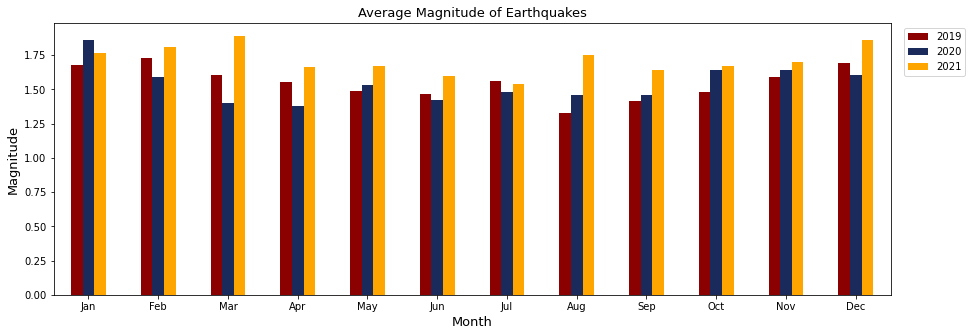

In [16]:
year_colors = {"2019": "darkred", "2020": "#1a2a5a", "2021": "orange"}
monthly_stats = {}
for year in years:
    # Group earthquakes according to month and calculate the average of each group
    avgValues = eq_processed_data[year].groupby(eq_processed_data[year]['EventTime'].dt.month)["mag"].mean()
    monthly_stats[year] = avgValues
# Creating a dataframe by combining all the values obtained for each year
monthly_stats_df = pd.concat([monthly_stats["2019"].rename("2019"), monthly_stats["2020"].rename("2020"),
                              monthly_stats["2021"].rename("2021")], axis=1)
# Plotting a bar chart with different color for every year
ax = monthly_stats_df.plot(kind='bar', figsize=(15,5), legend=True, y=years, color=year_colors)
ax.set_title("Average Magnitude of Earthquakes", fontsize=13)
ax.set_ylabel("Magnitude", fontsize=13)
ax.set_xlabel("Month", fontsize=13)
ax.set_xticklabels(months)
# Displaying the x axis labels horizontally
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.01, 1))
plt.show()    

The average magnitude of earthquakes every month for all the years is around 1.3 to 1.8. It is very similar for almost all the months. The average magnitude when calculated for the whole year was the highest for 2021 and even in case of month wise, 2021 has the highest average value for most of the months.

- Maximum magnitude of earthquakes month wise for each year.

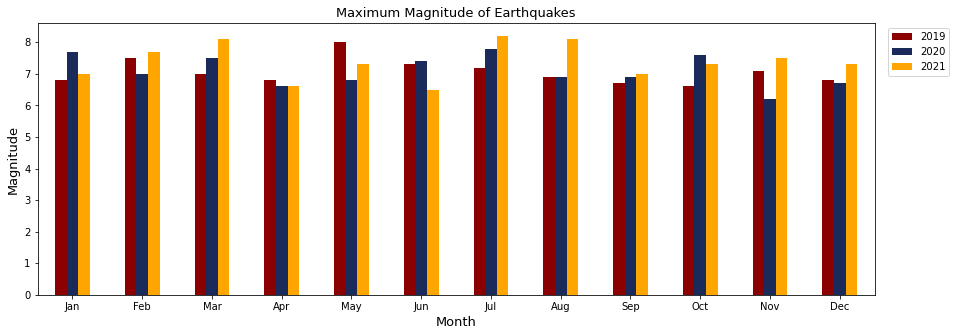

In [17]:
year_colors = {"2019": "darkred", "2020": "#1a2a5a", "2021": "orange"}
monthly_stats = {}
for year in years:
    # Group earthquakes according to month and calculate the maximum of each group
    maxValues = eq_processed_data[year].groupby(eq_processed_data[year]['EventTime'].dt.month)["mag"].max()
    monthly_stats[year] = maxValues
# Creating a dataframe by combining all the values obtained for each year
monthly_stats_df = pd.concat([monthly_stats["2019"].rename("2019"), monthly_stats["2020"].rename("2020"),
                              monthly_stats["2021"].rename("2021")], axis=1)    
# Plotting a bar chart with different color for every year
ax = monthly_stats_df.plot(kind='bar', figsize=(15,5), legend=True, y=years, color=year_colors)
ax.set_title("Maximum Magnitude of Earthquakes", fontsize=13)
ax.set_ylabel("Magnitude", fontsize=13)
ax.set_xlabel("Month", fontsize=13)
ax.set_xticklabels(months)
# Displaying the x axis labels horizontally
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.01, 1))
plt.show()    

It can be observed from the above plot that an earthquake with a magnitude of at least 6 has occured every month in all the three years. The year 2020 and 2021 have the highest magnitude of earthquakes during July. Comparitively, a large number of earthquakes also had occured during July for these two years. 

 - Grouping the earthquakes based on the magnitude and plotting a heatmap to check how many of them have occured every year.<br>
Categories:<br>
    - Great : Earthquakes with magnitude greater than 8<br>
    - Major : Earthquakes with magnitude between 7-8<br>
    - Strong : Earthquakes with magnitude between 6-7<br>
    - Moderate : Earthquakes with magnitude between 5-6<br>
    - Light : Earthquakes with magnitude between 4-5<br>
    - Minor : Earthquakes with magnitude between 3-4<br>
    - Micro : Earthquakes with magnitude less than 3<br>

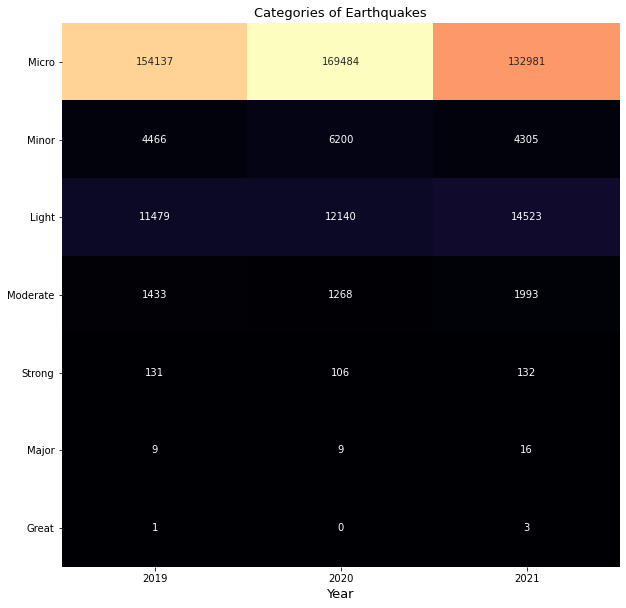

In [18]:
data = []
# Counting the number of earthquakes for each category every year
for year in years:
    category = {"Micro":0, "Minor":0, "Light":0, "Moderate":0, "Strong":0, "Major":0, "Great":0}
    for value in eq_processed_data[year]["mag"]:
        if value >= 8:
            category["Great"] += 1
        elif value >= 7:
            category["Major"] += 1
        elif value >= 6:
            category["Strong"] += 1
        elif value >= 5:
            category["Moderate"] += 1
        elif value >= 4:
            category["Light"] += 1
        elif value >= 3:
            category["Minor"] += 1
        else:
            category["Micro"] += 1          
    category["Year"] = year
    data.append(category)
# Creating a dataframe of all categories
df_mag_levels = pd.DataFrame(data).set_index("Year")
# Transposing to make the year as columns
df_mag_levels = df_mag_levels.transpose()
fig, ax = plt.subplots(figsize=(10, 10))
# Plotting a heatmap with different categories for every year
sns.heatmap(df_mag_levels, annot=True, cbar=False, fmt='.0f', cmap='magma')
ax.set_title('Categories of Earthquakes', fontsize=13)
ax.set_xlabel('Year', fontsize=13)
# Displaying the y axis labels horizontally
plt.yticks(rotation=0)
plt.show()

It can be observed from the plot, that majority of the earthquakes that have occured every year constitute the micro earthquakes. These micro earthquakes are not harmful and can only be felt and recorded by the sensors. Eventhough the year 2020 had the most number of earthquakes it had no great category earthquakes occured, but year 2019 and 2021 had 1 and 3 earthquakes of great category respectively that had occured. The great category earthquakes are very severe and can cause a lot of destruction. Strong earthquakes and Major earthquakes are also very harmful and occur very less when compared to other categories, but since they are harmful 100 strong earthquakes every year is still alarming. Earthquakes with magnitude between 4-5 have also occured a lot every year. These can be felt by most of the people and are mostly vibrations with no much severe damages.

- The place and date where the earthquakes with the maximum magitude have occured every year.

In [19]:
data = []
# Displaying the results in a table
print ('+-------------------------------------------+')
print ("| {:<5} | {:<9} | {:<8} | {:<9}  |".format('Year','Magnitude','Place','Date'))
print ('+-------------------------------------------+')
for year in years:
    # Finding the row with the maximum magnitude in that year
    mag_data = eq_processed_data[year].loc[eq_processed_data[year]["mag"].idxmax()]
    print ("| {:<5} | {:<9} | {:<8} | {:<9} |".format(year,mag_data['mag'],mag_data['place'],str(mag_data['EventTime'].date())))
print ('+-------------------------------------------+')

+-------------------------------------------+
| Year  | Magnitude | Place    | Date       |
+-------------------------------------------+
| 2019  | 8.0       | Peru     | 2019-05-26 |
| 2020  | 7.8       | Alaska   | 2020-07-22 |
| 2021  | 8.2       | Alaska   | 2021-07-29 |
+-------------------------------------------+


It can be observed from the above results, that the year 2020 and 2021 had the maximum magnitude earthquakes in Alaska and also both of them have occured during the end of July. Also, all the above earthquakes have occured during the end of that particular month in all the three years.

- Number of different places earthquakes have occured every year

In [20]:
# Displaying the results in a table
print ('+-----------------------+')
print ("| {:<5} | {:<13} |".format('Year','No. of places'))
print ('+-----------------------+')
for year in years:
     print ("| {:<5} | {:<13} |".format(year, eq_processed_data[year]["place"].nunique()))
print ('+-----------------------+')

+-----------------------+
| Year  | No. of places |
+-----------------------+
| 2019  | 349           |
| 2020  | 369           |
| 2021  | 394           |
+-----------------------+


It can be observed that earthquakes have occured in around 350-400 places all over the world every year. Eventhough 2021 had less number of earthquakes in total, it has more number of places where the earthquakes have occured than the other two years.<br>
Also, the number of places the eathquakes occur are increasing gradually every year.

- Significance value determines how significant an earthquake is. It takes into account all the factors like estimated impact, magnitude, reports and so on.
So, we now check the most significant earthquakes which have occured in that year for the last three years.

In [21]:
data = []
# Displaying the results in a table
print ('+----------------------------------------------------------------+')
print ("| {:<5} | {:<18} | {:<9} | {:<8} | {:<9}  |".format('Year','Significance Value', 'Magnitude','Place','Date'))
print ('+----------------------------------------------------------------+')
for year in years:
    # Finding the row with the maximum significance value in that year
    sig_data = eq_processed_data[year].loc[eq_processed_data[year]["sig"].idxmax()]
    print ("| {:<5} | {:<18} | {:<9} | {:<8} | {:<9} |".format(year,sig_data['sig'], sig_data['mag'],sig_data['place'],str(sig_data['EventTime'].date())))  
print ('+----------------------------------------------------------------+')

+----------------------------------------------------------------+
| Year  | Significance Value | Magnitude | Place    | Date       |
+----------------------------------------------------------------+
| 2019  | 2061               | 5.8       | China    | 2019-06-17 |
| 2020  | 1910               | 6.4       | Croatia  | 2020-12-29 |
| 2021  | 2502               | 7.0       | Mexico   | 2021-09-08 |
+----------------------------------------------------------------+


It can be observed from the above results, that the earthquakes with maximum magnitude in that year which we have obtained in the previous results are not the most significant events for that year. So, only magnitude cannot define the severity of the earthquakes, but also the place where the earthquakes occur and other factors make a huge impact. It can be seen in case of China where the magnitude of earthquake is less than 6 but it is still the most significant event.

- Top five places with the most number of earthquakes with a magnitude greater than or equal to 4 for each year.<br>
(Considering earthquakes with magnitude greater than or equal to 4 as they can be felt by people and can cause significant damage)

In [22]:
for year in years:
    print("\n\n-- %s" % year)
    # Considering only the data with magnitude greater than 4
    eq_data = eq_processed_data[year][eq_processed_data[year]['mag'] >= 4]
    # Grouping the earthquakes by place and calculating the total number
    places = eq_data.groupby('place')['place'].count().nlargest(5)
    places = places.to_frame()
    places.rename(columns={'place':'Count'}, inplace = True)
    # Displaying the results in a table
    print ('+----------------------------------------+')
    print ("| {:<30} | {:<5} |".format('Place', 'Count'))
    print ('+----------------------------------------+')
    for i, row in places.iterrows():
        print ("| {:<30} | {:<5} |".format(i, row['Count']))
    print ('+----------------------------------------+')



-- 2019
+----------------------------------------+
| Place                          | Count |
+----------------------------------------+
| Indonesia                      | 1945  |
| Philippines                    | 805   |
| Japan                          | 635   |
| Papua New Guinea               | 622   |
| Tonga                          | 503   |
+----------------------------------------+


-- 2020
+----------------------------------------+
| Place                          | Count |
+----------------------------------------+
| Indonesia                      | 1392  |
| Philippines                    | 684   |
| Japan                          | 662   |
| Papua New Guinea               | 581   |
| Tonga                          | 561   |
+----------------------------------------+


-- 2021
+----------------------------------------+
| Place                          | Count |
+----------------------------------------+
| Indonesia                      | 1576  |
| South Sandwich Islands

From the above results it can be observed that Indonesia has the most number of earthquakes in all the three years. Even Japan is in the top five places every year. Indonesia, Phillipines and Japan are earthquake prone countries and as expected they have a large number of earthquake every year.

- Considering the earthquakes occuring in oceanic regions. According to the data, the earthquakes with the flag 'tsunami' have occured in oceanic regions but there is no guarantee that a tsunami might have occured. <br>
Number of earthquakes that have occured in oceanic region and also the places where they have occured.

In [23]:
data=[]
for year in years:
    # Considering only the data where tsunami column has a value 1
    eq_data = eq_processed_data[year][eq_processed_data[year]['tsunami'] == 1]
    yearData ={}
    yearData["Year"] = year
    yearData["Count"] = len(eq_data)
    places = eq_data['place'].unique()
    # All the distinct places are stored comma separated
    yearData["Places"] = ",".join(places)
    data.append(yearData)
pd.set_option("max_colwidth", None)
high_sig_data = pd.DataFrame(data).set_index("Year")
display(high_sig_data)

,Count,Places
Year,,
2019,143,"Alaska,Southeastern Alaska,AK,Ridgecrest Earthquake Sequence,CA,OR,Puerto Rico,Peru,south of the Kermadec Islands,Aleutian Islands,Molucca Sea,Vanuatu,Chile,Mexico,Ecuador,South Sandwich Islands region,New Zealand,Kermadec Islands region,Japan,off the coast of Oregon,Banda Sea,Russia,Philippines,Canada,Indonesia,California,Papua New Guinea,New Caledonia,El Salvador,Northern Mariana Islands,Oregon,Fiji region,north of Ascension Island,Tonga,Nunavut,Canada region,Washington"
2020,131,"Alaska,northern Alaska,CA,B.C.,Washington,Jamaica,Cayman Islands,Kermadec Islands region,Chile,Indonesia,Japan,south of the Kermadec Islands,Mexico,South Sandwich Islands region,Philippines,Tonga,Papua New Guinea,Canada,Nunavut,Oregon,Aleutian Islands,Puerto Rico,Russia,Honduras,Japan region,Solomon Islands,California,Vanuatu,central Mid-Atlantic Ridge,Northwest Territories,Massachusetts,south of Alaska"
2021,108,"Alaska,Southern Alaska,CA,West Chile Rise,southeast of the Loyalty Islands,Japan,Vanuatu,Oregon,Beaufort Sea,New Zealand,east of the South Sandwich Islands,Aleutian Islands,Panama,Philippines,Indonesia,Mexico,South Sandwich Islands region,Haiti,Vanuatu region,Solomon Islands,off the coast of Oregon,Flores Sea,Argentina,South Shetland Islands,Russia,Wallis and Futuna,Nicaragua,Peru"


It can be observed that around 100 - 150 earthquakes have occured every year in oceanic regions and almost all the years similar places these earthquakes have occured which is expected, as the earthquakes in oceanic regions can ocur in places which are close to the water bodies.

- The place with the most number of earthquakes in the oceanic regions for each year.

In [24]:
data=[]
for year in years:
    eq_data = eq_processed_data[year][eq_processed_data[year]['tsunami'] == 1]
    # Grouping by place and counting the number of earthquakes
    placeCounts = eq_data.groupby('place')['place'].count()
    yearData ={}
    yearData["Year"] = year
    yearData['Place'] = placeCounts.idxmax()
    yearData['Count'] = placeCounts.max()
    data.append(yearData)
# Displaying the results in a table
print ('+---------------------------------+')
print ("| {:<5} | {:<15} | {:<5} |".format('Year','Place', 'Count'))
print ('+---------------------------------+')
for oc_data in data:
    print ("| {:<5} | {:<15} | {:<5} |".format(oc_data['Year'], oc_data['Place'], oc_data['Count']))
print ('+---------------------------------+')

+---------------------------------+
| Year  | Place           | Count |
+---------------------------------+
| 2019  | Alaska          | 69    |
| 2020  | Alaska          | 71    |
| 2021  | Alaska          | 44    |
+---------------------------------+


All the three years, Alaska has the most number of earthquakes and the number of earthquakes has comparitively decreased the last year in that region.

- Number of earthquakes that have occured based on the hour of the day.<br>
Plotting the number of earthquakes and also the number of earthquakes with magnitude greater than five that have occured every year based on hour, to check if higher magnitude earthquakes have occured when the number of earthquakes in total for that hour is more.

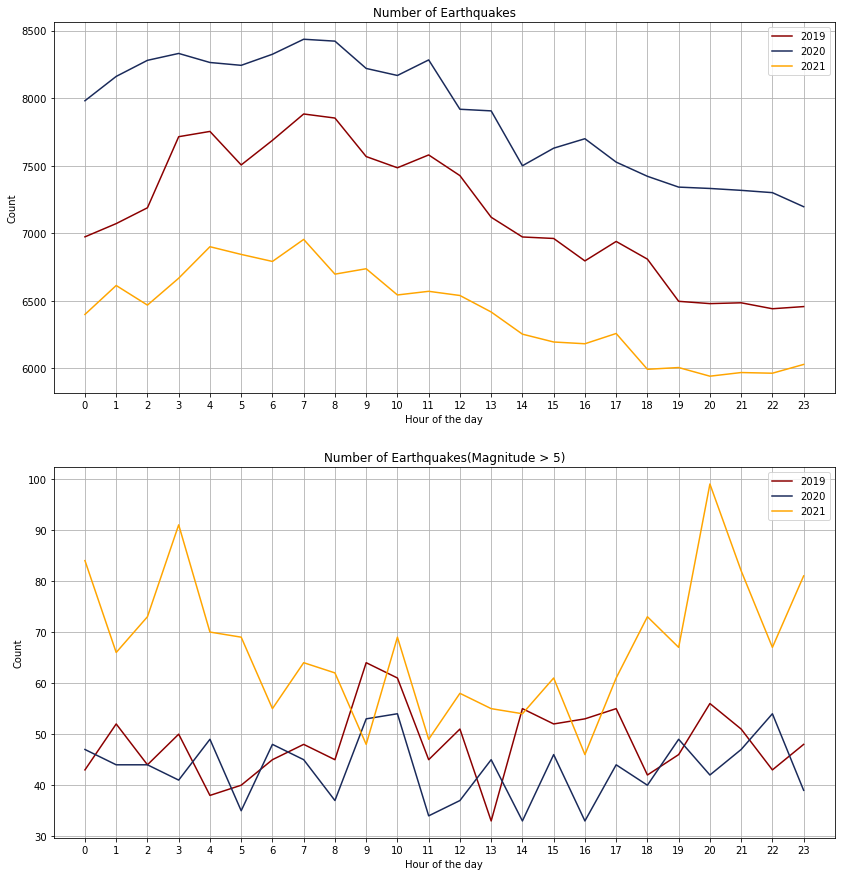

In [25]:
fig = plt.figure(figsize=(14,15))
hourly_stats = {}
# Calculating the counts for every hour of the day
for year in years:
    hour_data = eq_processed_data[year]['EventTime'].dt.hour
    hourly_stats[year] = hour_data.value_counts()
# Combining the results obtained of every year into a single dataframe
hourly_stats_df = pd.concat([hourly_stats["2019"].rename("2019"), hourly_stats["2020"].rename("2020"),
                              hourly_stats["2021"].rename("2021")], axis=1)    
axc = fig.add_subplot(2, 1, 1)
ax = hourly_stats_df.plot(ax=axc,legend=True, color=year_colors)
ax.set_title("Number of Earthquakes")
ax.set_ylabel("Count")
ax.set_xlabel("Hour of the day")
ax.set_xlim(hourly_stats_df.index.min() - 1, hourly_stats_df.index.max() + 1)
ax.set_xticks(np.arange(len(hourly_stats_df.index)))
ax.grid()


hourly_stats = {}
# Calculating the counts for every hour of the day for only the earthquakes with magnitude greater than 5 
for year in years:
    eq_data = eq_processed_data[year][eq_processed_data[year]['mag'] > 5]
    hour_data = eq_data['EventTime'].dt.hour
    hourly_stats[year] = hour_data.value_counts()
# Combining the results obtained of every year into a single dataframe
hourly_stats_df = pd.concat([hourly_stats["2019"].rename("2019"), hourly_stats["2020"].rename("2020"),
                              hourly_stats["2021"].rename("2021")], axis=1)
axc = fig.add_subplot(2, 1, 2)
ax = hourly_stats_df.plot(ax=axc,legend=True, color=year_colors)
ax.set_title("Number of Earthquakes(Magnitude > 5)")
ax.set_ylabel("Count")
ax.set_xlabel("Hour of the day")
ax.set_xlim(hourly_stats_df.index.min() - 1, hourly_stats_df.index.max() + 1)
ax.set_xticks(np.arange(len(hourly_stats_df.index)))
ax.grid()
plt.show()
fig.tight_layout()

It can be observed from the first plot that most of the earthquakes occur during the night time or early morning. The maximum number of earthquakes have occured during 6-8 AM in the morning in all the three years.
But when we consider the higher magnitude earthquakes, it can be observed from second plot that during 9-10 AM most earthquakes have occured in 2019 and 2020, but in 2021 most earthquakes have occured during 8-9 PM. So, the higher magnitude earthquakes have not occured a lot when the number of earthquakes as a whole in that hour is more.

- Considering the method or algorithm used for calculating the magnitude of earthquakes.

In [26]:
type_counts = {}
# Calculating the counts for the different types of magnitude measure method or algorithm
for year in years:
    magTypes = eq_processed_data[year]['magType']
    type_counts[year] = magTypes.value_counts()
# Combining the series obtained of every year into a single dataframe
type_counts_df = pd.concat([type_counts["2019"].rename("2019"), type_counts["2020"].rename("2020"),
                              type_counts["2021"].rename("2021")], axis=1)
type_counts_df = type_counts_df.fillna(0)
# Calculating the percentage of each method used in that year
type_counts_df = type_counts_df.div(type_counts_df.sum(axis=0)).multiply(100).round(3).astype(str).add(' %')
display(type_counts_df)

,2019,2020,2021
ml,73.135 %,69.075 %,61.751 %
md,18.71 %,23.352 %,27.098 %
mb,6.789 %,6.435 %,9.872 %
mww,0.674 %,0.617 %,0.779 %
mb_lg,0.196 %,0.118 %,0.099 %
mwr,0.174 %,0.264 %,0.255 %
mlr,0.142 %,0.001 %,0.002 %
mw,0.126 %,0.08 %,0.088 %
mh,0.054 %,0.053 %,0.048 %
mwc,0.001 %,0.0 %,0.001 %


It can be observed that ml algorithm is the most used in all the three years. This method is the most used as it is preferred for earthquakes with magnitude less than 4 and as we've seen previously most of the earthquakes that occur are of magnitude less than 4. mb and md are usually used for earthquakes with magnitude 4 - 6.5 and hence are the mostly used method after ml.

 - Considering the average gap and rms values for each year.<br>
gap value determines the data reliability of the location of the earthquake.<br>
rms value determines the reliability of the earthquake arrival time(observed and predicted).

In [27]:
# Displaying the results in a table
print ('+-------------------------------------+')
print ("| {:<5} | {:<12} | {:<12} |".format('Year','gap average', 'rms average'))
print ('+-------------------------------------+')
for year in years:
    print ("| {:<5} | {:<12.2f} | {:<12.2f} |".format(year,eq_processed_data[year]["gap"].mean(), eq_processed_data[year]["rms"].mean()))
print ('+-------------------------------------+')

+-------------------------------------+
| Year  | gap average  | rms average  |
+-------------------------------------+
| 2019  | 137.22       | 0.30         |
| 2020  | 132.94       | 0.27         |
| 2021  | 138.11       | 0.30         |
+-------------------------------------+


It can be observed that the average of the gap values for each year is around 130-140. If the value is less than 180 then it is a reliable value. So, in this case the location of the earthquake detected is reliable as the values are in the required range.
Lesser the rms values, more reliable and accurate is the data.
Since, these two values are within the required range, the data of earthquakes is reliable and accurate.

## Conclusion
In this assigment analysis was done on earthquakes data for the previous three years. There are almost 150,000 earthquakes that have occured every year, which includes a huge number of micro(< 3 magnitude) earthquakes which cannot be felt by the people. As expected, a lot of severe earthquakes occur in the earthquake prone areas such as Japan, Indonesia, Alaska, China and so on. Most of the earthquakes occur during the early morning period. Magnitude is not the only factor which determines the severity of an earthquake and a lot of factors combined makes an earthquake severe. Every year the earthquakes are occuring in a lot more places than previously.<br>
<br>
One challenge for collecting the data from USGS Earthquake Catalog API was the limit on the amount of data that could be retrieved at once. Only a maximum of 20,000 records at once could be retrieved. Hence the API had to be invoked multiple times for retrieving the data for all the three years.<br>
The data also had a lot of missing values, some of the columns hardly had any data and hence required a lot of cleaning and pre-processing before analysing the data.<br>
<br>
Further analysis that could be performed on this data is that we can predict the various months and the time when an earthquake could occur in a particular place. If the alert and felt column had no many missing values, we could also predict the alert level and estimate the impact that could occur by considering the number of felt reports. The magnitde of the earthquake also could be predicted based on the time and place. As, the number of places where the earthquakes occur are increasing, we can predict which new place the earthquakes might occur. If we collect the data for a lot more years, we can predict the trend of changes over a decade.